# PD120 调制

In [2]:
import numpy as np
import pathlib
import itertools
from IPython.display import Audio
from importlib import reload
import pandas as pd
from PIL import Image
import io
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import scienceplots
# 设置 SciencePlots 样式
plt.style.use(['notebook', 'grid'])

In [3]:
def stft_plot(current_processed_analytic_signal, sample_rate=48000, low_freq=-2000, high_freq=2000):
  from scipy.signal import stft
  nperseg = 2048  # 窗口大小，决定频率分辨率
  noverlap = nperseg // 2 # 50% 重叠
  f, t_stft, Zxx = stft(current_processed_analytic_signal, fs=sample_rate, nperseg=nperseg, noverlap=noverlap, window='hann')
  print(f"STFT 结果维度: 频率 {Zxx.shape[0]}, 时间 {Zxx.shape[1]}")
  print(f"原始频率范围: [{f.min():.2f}, {f.max():.2f}] Hz")
  # --- 4. 可视化频谱图 ---
  # 将 Zxx 的幅值转换为 dB 尺度
  magnitude_spectrum_db = 10 * np.log10(np.abs(Zxx) + 1e-10) # 加上一个很小的值防止log(0)
  plt.figure(figsize=(15, 6))
  # --- 子图 2: 经过 fftshift 处理后的 STFT 结果 (零频率居中) ---
  # 将频率轴和频谱数据进行 fftshift 移位，使零频率居中
  # 对于 STFT 结果 Zxx，我们需要对频率轴 (0轴) 进行 fftshift
  Zxx_shifted = np.fft.fftshift(Zxx, axes=0)
  f_shifted = np.fft.fftshift(f)
  magnitude_spectrum_shifted_db = 10 * np.log10(np.abs(Zxx_shifted) + 1e-10)
  plt.pcolormesh(t_stft, f_shifted, magnitude_spectrum_shifted_db, shading='gouraud', vmin=-60, vmax=0)
  plt.colorbar(label='Magnitude (dB)')
  plt.title('Spectrogram of Complex Signal (Zero Frequency Centered)')
  plt.ylabel('Frequency [Hz]')
  plt.xlabel('Time [s]')
  # plt.ylim([f.min(), f.max()]) # 确保显示完整频率范围
  plt.ylim([low_freq, high_freq])
  plt.tight_layout()
  plt.show()

## 关于 PD 120

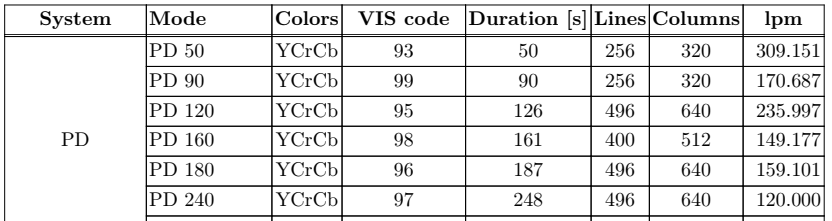

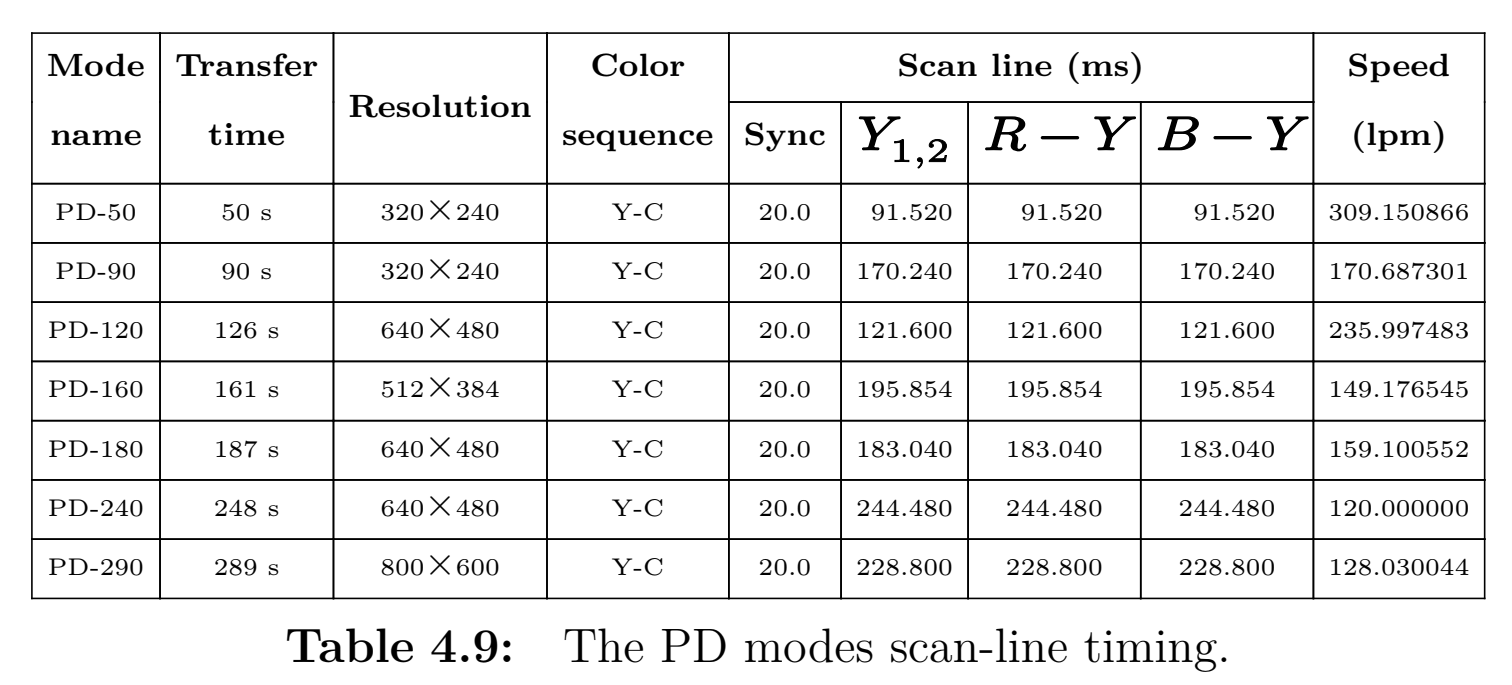

## VIS

1. PD 120 方式的 VIS 值为 95 : 101 1111；

### 一些细节

1. Leader Burst (引导脉冲)： 每个 300 毫秒，1900 Hz
2. Break (间隔/断点)： 10 毫秒，1200 Hz，位于两个脉冲之间
3. 7-bit VIS (7 位 VIS 标识数据)： 30 毫秒，0 (Logic 0) 1300 Hz，1 (Logic 1) 1100 Hz，低位先行
4. Even Parity Bit (偶校验位)： 30 毫秒，SSTV 为偶校验，对应频率与位编码相同
5. Start/Stop Bit (开始/停止位)： 30 毫秒，1200 Hz，分别位于 VIS Code 之前和之后

发送顺序为 Leader Burst + Break + Start Bit + 7-bit VIS + Even Parity Bit + Stop Bit

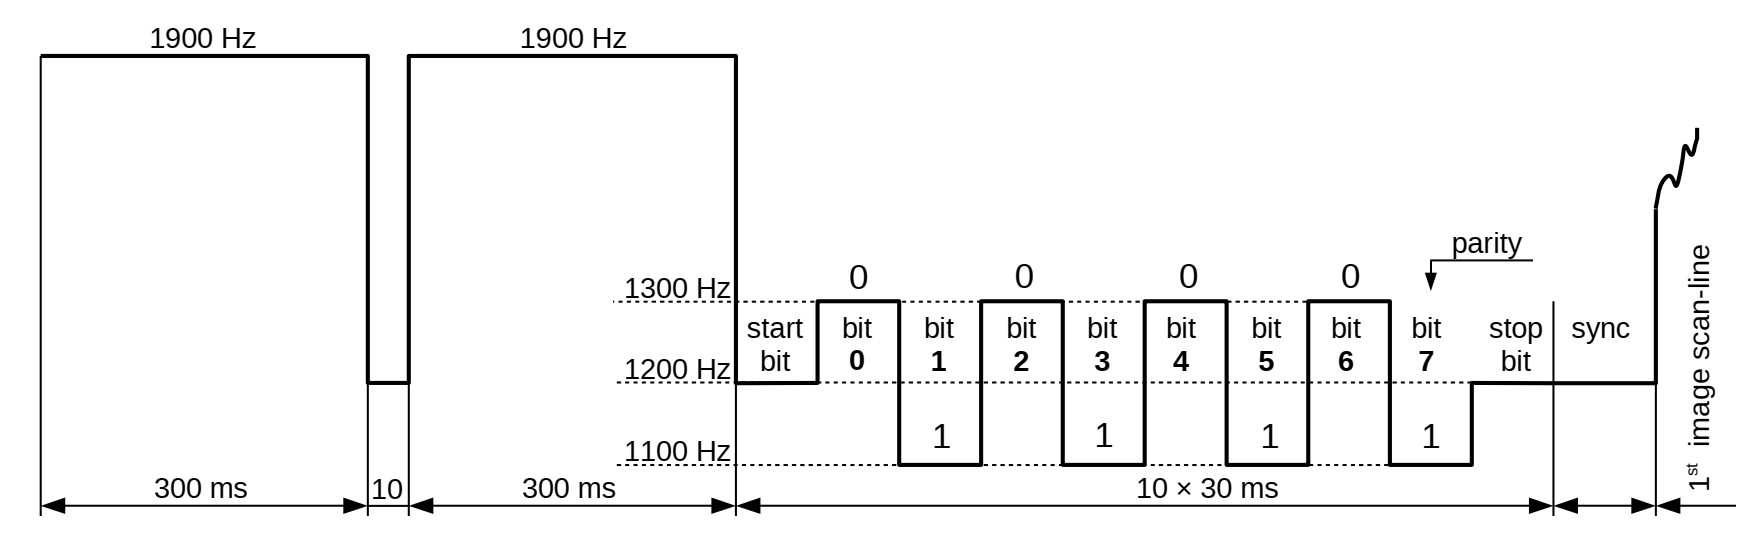

查看一些实现，VIS 前有一个额外的前导码：1900 Hz + 1500 Hz + 1900 Hz+ 1500 Hz + 2300 Hz + 1500 Hz + 2300 Hz + 1500 Hz，单个码 100ms，总共 800ms

因此加起来 1.71s

| 序号 | 作用                 | 频率 (Hz) | 持续时间 (ms) | 累计时间 (ms) |
| :--- | :------------------- | :-------- | :------------ | :------------ |
| **1.** | **Preamble Tones**   |           |               |               |
| 1    | Preamble             | 1900      | 100           | 100           |
| 2    | Preamble             | 1500      | 100           | 200           |
| 3    | Preamble             | 1900      | 100           | 300           |
| 4    | Preamble             | 1500      | 100           | 400           |
| 5    | Preamble             | 2300      | 100           | 500           |
| 6    | Preamble             | 1500      | 100           | 600           |
| 7    | Preamble             | 2300      | 100           | 700           |
| 8    | Preamble             | 1500      | 100           | 800           |
| **2.** | **VIS Code Start Tones** |           |               |               |
| 9    | Leader Burst 1       | 1900      | 300           | 1100          |
| 10   | Break                | 1200      | 10            | 1110          |
| 11   | Leader Burst 2       | 1900      | 300           | 1410          |
| 12   | Start Bit (for data) | 1200      | 30            | 1440          |
| **3.** | **7-bit VIS Data (1111101)** |           |               |               |
| 13   | Bit 0 ('1')          | 1100      | 30            | 1470          |
| 14   | Bit 1 ('1')          | 1100      | 30            | 1500          |
| 15   | Bit 2 ('1')          | 1100      | 30            | 1530          |
| 16   | Bit 3 ('1')          | 1100      | 30            | 1560          |
| 17   | Bit 4 ('1')          | 1100      | 30            | 1590          |
| 18   | Bit 5 ('0')          | 1300      | 30            | 1620          |
| 19   | Bit 6 ('1')          | 1100      | 30            | 1650          |
| **4.** | **Even Parity Bit**  |           |               |               |
| 20   | Parity ('0')         | 1300      | 30            | 1680          |
| **5.** | **Stop Bit**         |           |               |               |
| 21   | Stop Bit             | 1200      | 30            | 1710          |

In [4]:
# --- 1. 定义常量 ---
SAMPLE_RATE = 48000  # 采样率 (Hz)
AMPLITUDE = 0.8      # 音频信号的峰值幅度 (0.0 到 1.0)

# 频率映射
FREQ_LOGIC_0 = 1300 # Hz
FREQ_LOGIC_1 = 1100 # Hz
FREQ_BREAK = 1200   # Hz
FREQ_START_STOP = 1200 # Hz
FREQ_LEADER_BURST = 1900 # Hz

# VIS 95 的 7-bit 数据 (低位先行)
# 95 decimal -> 1011111 binary
# Low bit first: 1111101
VIS_BITS = [1, 1, 1, 1, 1, 0, 1] # bit0, bit1, bit2, bit3, bit4, bit5, bit6

# 计算偶校验位
# 统计 VIS_BITS 中 '1' 的数量
num_ones = sum(VIS_BITS)
# 如果 '1' 的数量是偶数，校验位是 '0' (保持偶数)
# 如果 '1' 的数量是奇数，校验位是 '1' (使其变为偶数)
PARITY_BIT = 0 if num_ones % 2 == 0 else 1
PARITY_FREQ = FREQ_LOGIC_0 if PARITY_BIT == 0 else FREQ_LOGIC_1

print(f"VIS 95 (decimal) in 7-bit (low bit first): {VIS_BITS}")
print(f"Number of '1's in VIS_BITS: {num_ones}")
print(f"Even Parity Bit for VIS 95: {PARITY_BIT} (Frequency: {PARITY_FREQ} Hz)")

VIS 95 (decimal) in 7-bit (low bit first): [1, 1, 1, 1, 1, 0, 1]
Number of '1's in VIS_BITS: 6
Even Parity Bit for VIS 95: 0 (Frequency: 1300 Hz)


In [5]:
import math

# --- 2. `generate_tone` 辅助函数 ---
def generate_tone(frequency_hz: float, duration_ms: float, initial_phase_rad: float):
    """
    生成一个指定频率、持续时间和起始相位的正弦波形片段。
    保持相位连续性是关键。

    Args:
        frequency_hz: 音调的频率 (Hz)。
        duration_ms: 音调的持续时间 (毫秒)。
        initial_phase_rad: 音调的起始相位 (弧度)。

    Returns:
        tuple: (生成的波形 (NumPy 数组), 结束相位 (弧度))
    """
    num_samples = int(SAMPLE_RATE * duration_ms / 1000.0)
    if num_samples == 0:
        return np.array([]), initial_phase_rad

    # 生成时间向量 (从0开始，不包含最后一个点，以避免与下一个波形的时间重叠)
    t = np.linspace(0, duration_ms / 1000.0, num_samples, endpoint=False)

    # 生成正弦波形
    # f * t 是角频率 * 时间，加上 initial_phase_rad 确保相位连续
    waveform_segment = AMPLITUDE * np.sin(2 * math.pi * frequency_hz * t + initial_phase_rad)

    # 计算该段波形结束时的相位
    # 确保相位在 0 到 2*pi 之间
    ending_phase_rad = (2 * math.pi * frequency_hz * (duration_ms / 1000.0) + initial_phase_rad) % (2 * math.pi)

    return waveform_segment, ending_phase_rad

In [6]:
# --- 3. 构建音调序列 ---
all_audio_segments = []
current_phase = 0.0  # 初始相位设为 0

# 定义音调规格列表 (频率, 持续时间)
# 1. Preamble Tones (800ms)
header_tones_spec = [
    # Preamble
    (1900, 100, "Preamble 1"), (1500, 100, "Preamble 2"),
    (1900, 100, "Preamble 3"), (1500, 100, "Preamble 4"),
    (2300, 100, "Preamble 5"), (1500, 100, "Preamble 6"),
    (2300, 100, "Preamble 7"), (1500, 100, "Preamble 8"),

    # VIS Code Start Tones
    (FREQ_LEADER_BURST, 300, "Leader Burst 1"),
    (FREQ_BREAK, 10, "Break"),
    (FREQ_LEADER_BURST, 300, "Leader Burst 2"),
    (FREQ_START_STOP, 30, "Start Bit (for data)"),
]

# 添加 VIS 7-bit 数据
for i, bit in enumerate(VIS_BITS):
    freq = FREQ_LOGIC_0 if bit == 0 else FREQ_LOGIC_1
    header_tones_spec.append((freq, 30, f"Bit {i} ('{bit}')"))

# 添加偶校验位
header_tones_spec.append((PARITY_FREQ, 30, f"Parity ('{PARITY_BIT}')"))

# 添加停止位
header_tones_spec.append((FREQ_START_STOP, 30, "Stop Bit"))

print(f"SSTV VIS header (PD120, VIS 95) generated successfully!")

SSTV VIS header (PD120, VIS 95) generated successfully!


## 数据部分

PD120 的核心特点是采用 **YCrCb（亮度、色差红、色差蓝）** 色彩空间，并且采用了**每两行像素合并发送一次色差信号**的策略。

### 1. 调制方式：模拟调频 (FM)
SSTV 并不是数字信号，而是将图像亮度或颜色数值转换成特定的**音频频率**进行模拟调制。
*   **同步频率:** 1200 Hz
*   **黑电平频率:** 1500 Hz
*   **白电平频率:** 2300 Hz
*   **亮度/颜色范围:** 1500 Hz 到 2300 Hz 之间的线性映射（代表 0-255 的灰度或色彩值）。

---

### 2. 同步信号 (Synchronization)
在 PD120 中，并不是每一行都有一个独立的同步脉冲。它是以**两行（一组）**为单位进行同步的。

*   **行起始同步:** 频率为 **1200 Hz**，持续时间为 **20 ms**。
*   **同步后沿:** 频率为 **1500 Hz**（黑色电平），持续时间为 **2.08 ms**。这个信号用于告诉接收端准备接收数据。

---

### 3. 数据信号结构 (Data Signal Structure)
PD120 的数据传输序列非常特殊。为了提高效率，它将两行连续的图像像素打包成一个传输单元。

一个完整的传输周期（包含 2 行图像）的顺序如下：
1.  **Sync + Porch** (22.08 ms)
2.  **Y₁ (第 1 行亮度):** 记录第 1 行所有像素的亮度。
3.  **R-Y (色差红):** 记录这**两行**像素的平均色差红。
4.  **B-Y (色差蓝):** 记录这**两行**像素的平均色差蓝。
5.  **Y₂ (第 2 行亮度):** 记录第 2 行所有像素的亮度。

**结论：** 每一行都有独立的亮度信息（保证了垂直分辨率），但每两行共用一套色差信息（降低了色彩分辨率以节省带宽，由于人眼对亮度更敏感，这种压缩几乎不损失视觉质量）。

---

### 4. 像素频率与时长调制 (Timing & Frequency)

根据技术规格数据，我们可以精确计算 PD120 的每一个像素细节：

#### (1) 扫描行参数
*   **总行数:** 496 行。
*   **每行像素数:** 640 像素。
*   **每组时长 (2行):** 约 508.48 ms。

#### (2) 每一段信号的持续时长 (T)
根据标准数值 Y/R-Y/B-Y = 121.600 ms：
*   **Y₁ 持续时间:** 121.6 ms
*   **R-Y 持续时间:** 121.6 ms
*   **B-Y 持续时间:** 121.6 ms
*   **Y₂ 持续时间:** 121.6 ms

#### (3) 单个像素调制时长 (t_pixel)
在 PD120 模式下，每行 640 个像素要在 121.6 ms 内传完：

`t_pixel = 121.6 ms / 640 pixels = 0.19 ms = 190 μs`

即：**每 190 微秒，信号的频率就会根据下一个像素的数值发生变化。**

#### (4) 频率计算公式
对于任何一个像素点（亮度 Y 或色差 C），其发射频率 f 为：

`f = 1500 + (PixelValue / 255 * 800) Hz`

*   若像素值为 0（黑/无色）：1500 Hz
*   若像素值为 255（最亮/最红/最蓝）：2300 Hz
*   若像素值为 128（中间值）：1901.5 Hz

---

### 5. VIS 编码（识别码）
在图像正式开始传输前，会发送一个 **VIS (Video Integration Process)** 码。
*   **PD120 的 VIS 码为:** 95。
*   这是一个数字编码，由起始位、7位数据位、奇偶校验位和停止位组成。
*   接收端软件（如 MMSSTV）通过识别频率为 1900Hz 和 1100Hz 的跳变信号来获取这个代码，从而自动切换到 PD120 模式。

---

### 6. 总结 PD120 的一个完整传输循环（2行数据）

| 信号部分 | 持续时间 | 频率 | 说明 |
| :--- | :--- | :--- | :--- |
| **Sync** | 20.0 ms | 1200 Hz | 行组起始同步信号 |
| **Porch** | 2.08 ms | 1500 Hz | 黑色间歇 |
| **Y₁ (Line 1)** | 121.6 ms | 1500-2300 Hz | 第1行亮度（640像素） |
| **R-Y (Cr)** | 121.6 ms | 1500-2300 Hz | 第1&2行共用的红色差 |
| **B-Y (Cb)** | 121.6 ms | 1500-2300 Hz | 第1&2行共用的蓝色差 |
| **Y₂ (Line 2)** | 121.6 ms | 1500-2300 Hz | 第2行亮度（640像素） |
| **总计** | **508.48 ms** | | **完成 2 行扫描** |

PD120 在大约 **126秒** 内完成了 640 * 496 像素的高清图像传输。

In [7]:
# RGB 色彩转换到 BT.601 Limited Range
WIDTH, HEIGHT = 640, 496
image_obj = Image.open('No-Signal-TV_small.png')
if image_obj.mode != 'RGB':
  image_obj = image_obj.convert('RGB')
image_data = np.array(image_obj, dtype=np.int32)

R = image_data[:, :, 0].astype(np.float32)
G = image_data[:, :, 1].astype(np.float32)
B = image_data[:, :, 2].astype(np.float32)

Y  = 16.0  + (0.256789 * R + 0.504129 * G + 0.097906 * B)
Cb = 128.0 + (-0.148223 * R - 0.290992 * G + 0.439215 * B)
Cr = 128.0 + (0.439215 * R - 0.367789 * G - 0.071426 * B)

Y = np.clip(Y, 16, 235)
Cb = np.clip(Cb, 16, 240)
Cr = np.clip(Cr, 16, 240)

Y.shape

(573, 640)

In [8]:
# 频率定义 (Hz)
FREQ_SYNC = 1200
FREQ_BLACK = 1500
FREQ_WHITE = 2300
FREQ_RANGE = FREQ_WHITE - FREQ_BLACK       # 2300 - 1500

data_tones_spec = []
for i in range(0, HEIGHT, 2):
  data_tones_spec.append((FREQ_SYNC, 20, f"Sync pulse {i}"))
  data_tones_spec.append((FREQ_BLACK, 2.08, f"Porch pulse {i}"))
  for j in range(0, WIDTH):
    data_tones_spec.append((FREQ_BLACK + (Y[i][j] / 255.0) * FREQ_RANGE, 0.19, f"Y pos {i}, {j}"))
  for j in range(0, WIDTH):
    data_tones_spec.append((FREQ_BLACK + ((Cr[i][j] + Cr[i+1][j]) / 2.0 / 255.0) * FREQ_RANGE, 0.19, f"Y pos {i}, {j}"))
  for j in range(0, WIDTH):
    data_tones_spec.append((FREQ_BLACK + ((Cb[i][j] + Cb[i+1][j]) / 2.0 / 255.0) * FREQ_RANGE, 0.19, f"Y pos {i}, {j}"))
  for j in range(0, WIDTH):
    data_tones_spec.append((FREQ_BLACK + (Y[i + 1][j] / 255.0) * FREQ_RANGE, 0.19, f"Y pos {i + 1}, {j}"))
    
len(data_tones_spec)

635376

## Full Audio

In [9]:
# 生成所有音频
all_tones_spec = header_tones_spec + data_tones_spec

total_duration_ms = sum(item[1] for item in all_tones_spec)
total_samples = int(np.round(total_duration_ms / 1000.0 * SAMPLE_RATE))
total_duration_ms, total_samples

(127813.04000102026, 6135026)

In [10]:
freq_array = np.zeros(total_samples, dtype=np.float64)

current_sample_idx = 0
cumulative_time_ms = 0.0

for i, (freq, duration_ms, description) in enumerate(all_tones_spec):
    cumulative_time_ms += duration_ms
    # 关键点：计算该段结束时的精确全局样本索引，消除舍入误差累积
    next_sample_idx = int(np.round(cumulative_time_ms / 1000.0 * SAMPLE_RATE))
    
    # 填充该段对应的频率
    if next_sample_idx > current_sample_idx:
        freq_array[current_sample_idx:next_sample_idx] = freq
        
    current_sample_idx = next_sample_idx

# --- 核心积分步骤 ---
# 1. 计算相位增量: d_phi = 2 * pi * f(t) * dt
# 其中 dt = 1 / sample_rate
phase_deltas = (2.0 * np.pi * freq_array) / SAMPLE_RATE

# 2. 对相位增量求和得到瞬时相位
# 使用 cumsum 模拟积分
phases = np.cumsum(phase_deltas)

# 3. 生成正弦波
full_waveform = AMPLITUDE * np.sin(phases)

# 合并所有音频片段
full_waveform.shape, full_waveform.shape[0] / SAMPLE_RATE

((6135026,), 127.81304166666666)

STFT 结果维度: 频率 1025, 时间 203
原始频率范围: [0.00, 24000.00] Hz


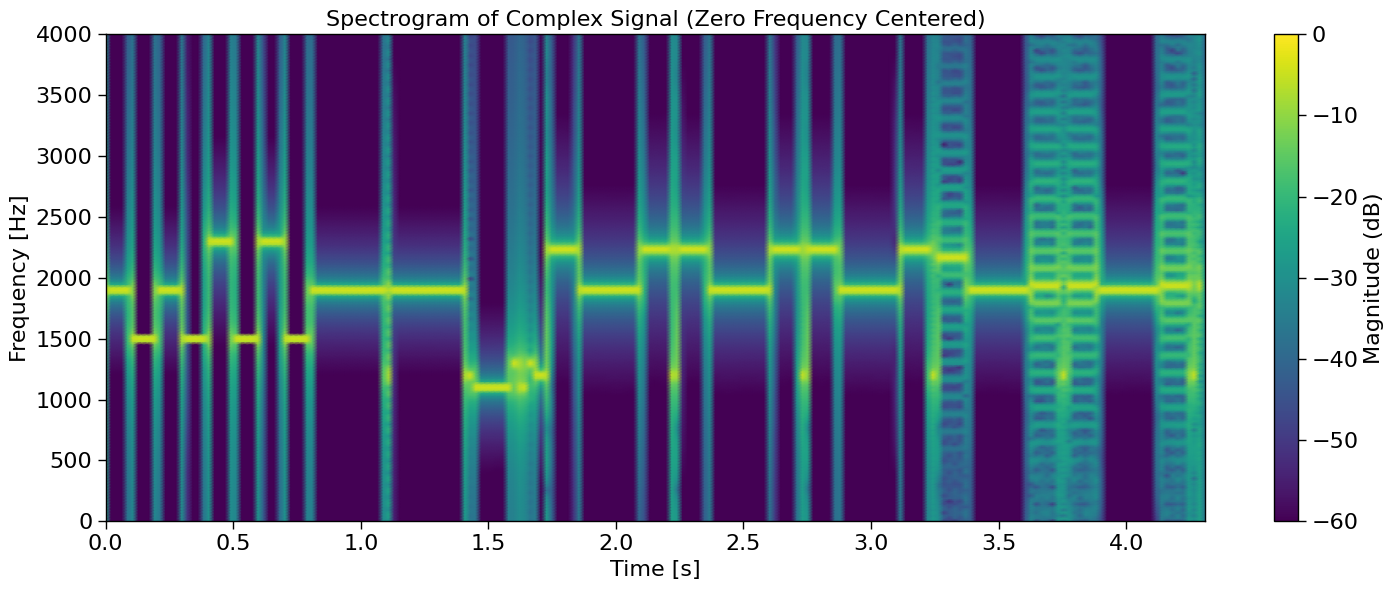

In [11]:
stft_plot(full_waveform[0: 206000], low_freq=0, high_freq=4000)

## 储存数据

In [13]:
import scipy.io.wavfile as wavfile

# --- 保存 WAV 文件 ---
# 将浮点数波形转换为 16 位整数 (常见 WAV 格式)
# 限制幅度在 -1 到 1 之间，然后乘以 32767 (2^15 - 1)
OUTPUT_FILENAME = 'pd120_full_signal.wav'
audio_int16 = np.int16(full_waveform * 32767)

wavfile.write(OUTPUT_FILENAME, SAMPLE_RATE, audio_int16)

正在重采样: 48000 -> 11025 Hz...
重采样完成。新数据长度: 1409139
填充后样本数: 1411187
STFT 结果维度: 频率 1025, 时间 119
原始频率范围: [0.00, 5512.50] Hz


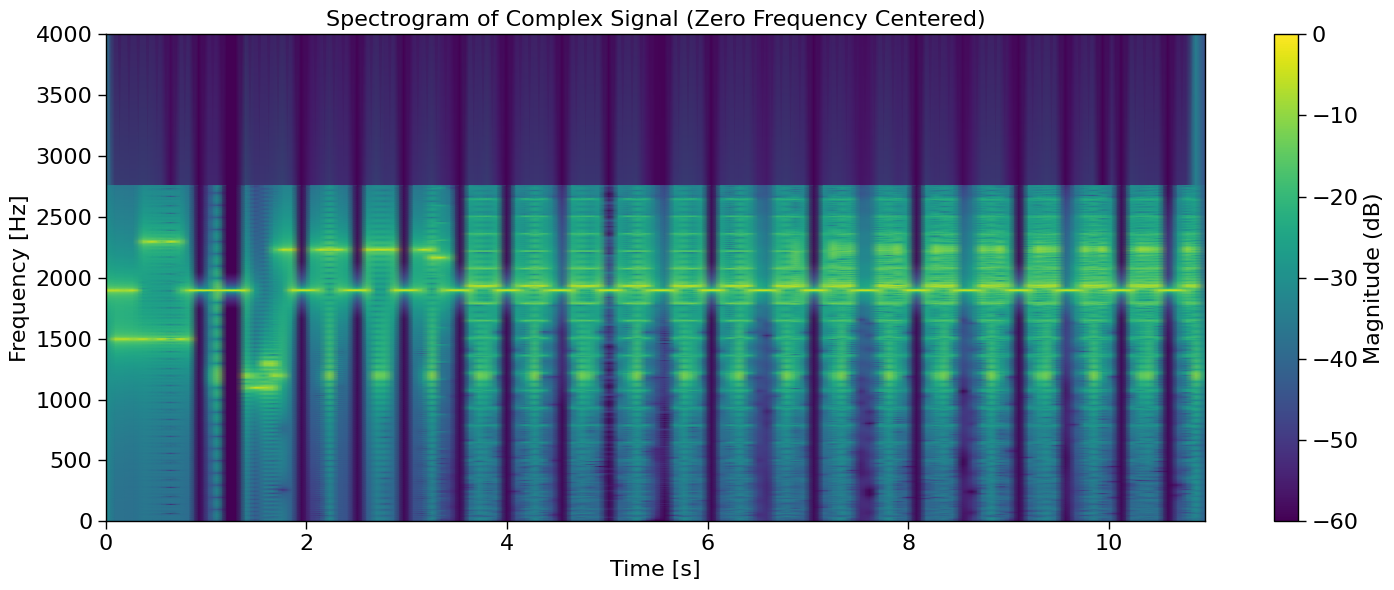

In [16]:
import librosa
import os

output_raw = "pd120_11025Hz.raw"
target_sr = 11025

if SAMPLE_RATE != target_sr:
    print(f"正在重采样: {SAMPLE_RATE} -> {target_sr} Hz...")
    audio_data = librosa.resample(full_waveform, orig_sr=SAMPLE_RATE, target_sr=target_sr)
    print(f"重采样完成。新数据长度: {len(audio_data)}")
    
# 末尾补充 0 值
audio_data_padded = np.pad(audio_data, (0, 2048), mode='constant', constant_values=0)
print(f"填充后样本数: {len(audio_data_padded)}")

stft_plot(audio_data_padded[0:120000], target_sr, low_freq=0, high_freq=4000)

In [17]:
# 保存为 Raw Binary 文件 (Float32)
print(f"正在写入原始数据文件: {output_raw}")
with open(output_raw, 'wb') as f:
    f.write(audio_data_padded.astype(dtype=np.float32).tobytes())

# 验证文件大小 (样本数 * 4字节/float32)
file_size = os.path.getsize(output_raw)
print(f"输出文件大小: {file_size} 字节")

正在写入原始数据文件: pd120_11025Hz.raw
输出文件大小: 5644748 字节
